In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr
from scipy.linalg import svd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✅ All imports successful!")

✅ All imports successful!


# CELL 1: TẠO TOY DATA


In [2]:
# Toy data ratings matrix
ratings = pd.DataFrame({
    'I1': [4.0, 3.0, np.nan, 2.0],
    'I2': [3.0, 3.0, 4.0, 1.0],
    'I3': [np.nan, 5.0, 4.0, 2.0],
    'I4': [4.0, np.nan, 5.0, 3.0]
}, index=['U1', 'U2', 'U3', 'U4'])

print("📊 User × Item Rating Matrix:")
print(ratings)
print(f"\n⚠️  Sparsity: {ratings.isna().sum().sum() / ratings.size * 100:.1f}%")

# Toy data movies (cho content-based)
movies_df = pd.DataFrame({
    'title': ['A', 'B', 'C', 'D'],
    'genres': ['Action|Adventure', 'Drama', 'Action|Sci-Fi', 'Comedy|Drama'],
    'v': [120, 45, 300, 15],
    'R': [7.2, 8.0, 6.9, 9.0]
})

print("\n🎬 Movies Data:")
print(movies_df)

📊 User × Item Rating Matrix:
     I1   I2   I3   I4
U1  4.0  3.0  NaN  4.0
U2  3.0  3.0  5.0  NaN
U3  NaN  4.0  4.0  5.0
U4  2.0  1.0  2.0  3.0

⚠️  Sparsity: 18.8%

🎬 Movies Data:
  title            genres    v    R
0     A  Action|Adventure  120  7.2
1     B             Drama   45  8.0
2     C     Action|Sci-Fi  300  6.9
3     D      Comedy|Drama   15  9.0


# CELL 2: HÀNG ĐỢI TRỢ GIÚP (HELPER FUNCTIONS)

In [3]:
def safe_pearsonr(a, b):
    """
    Tính Pearson correlation an toàn
    Trả về (r, p_value) hoặc (np.nan, np.nan) nếu không tính được
    """
    try:
        if len(a) < 2 or len(b) < 2:
            return np.nan, np.nan
        if np.std(a) == 0 or np.std(b) == 0:  # Một trong hai constant
            return np.nan, np.nan
        r, p = pearsonr(a, b)
        return r, p
    except Exception as e:
        print(f"⚠️  Pearson error: {e}")
        return np.nan, np.nan

def normalize_scores(scores):
    """Chuẩn hóa điểm về [0, 1]"""
    if isinstance(scores, (list, np.ndarray)):
        scores = np.array(scores)
    else:
        scores = scores.values
    
    s_min, s_max = scores.min(), scores.max()
    if s_max == s_min:
        return np.ones_like(scores) * 0.5
    return (scores - s_min) / (s_max - s_min)

def print_section(title):
    """In tiêu đề section"""
    print(f"\n{'='*60}")
    print(f"🔹 {title}")
    print(f"{'='*60}\n")

print("✅ Helper functions loaded!")

✅ Helper functions loaded!


# CELL 3: BÀI 1.1 - EUCLIDEAN & MANHATTAN (MỌI TRƯỜNG HỢP)

In [4]:
print_section("BÀI 1.1: EUCLIDEAN & MANHATTAN DISTANCE")

# ============ TRƯỜNG HỢP 1: Tính bình thường ============
def calc_distances(ratings):
    """Tính Euclidean & Manhattan giữa mọi cặp user"""
    users = ratings.index.tolist()
    results = []
    
    for i in range(len(users)):
        for j in range(i + 1, len(users)):
            u, v = users[i], users[j]
            pair = ratings.loc[[u, v]].dropna(axis=1)  # chỉ item đồng đánh giá
            
            # Trường hợp: không có item chung
            if pair.shape[1] == 0:
                results.append({
                    'u': u, 'v': v,
                    'common_items': 0,
                    'euclidean': np.inf,
                    'manhattan': np.inf,
                    'note': 'No common items'
                })
                continue
            
            a, b = pair.iloc[0].values, pair.iloc[1].values
            euc = euclidean(a, b)
            man = cityblock(a, b)
            
            results.append({
                'u': u, 'v': v,
                'common_items': pair.shape[1],
                'euclidean': float(euc),
                'manhattan': float(man),
                'note': 'OK'
            })
    
    return pd.DataFrame(results)

dist_df = calc_distances(ratings)
print(dist_df.to_string(index=False))

# ============ TRƯỜNG HỢP 2: Tính khoảng cách chuẩn hóa (normalized) ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: Normalized Distance (0-1)")
print("="*60 + "\n")

def calc_distances_normalized(ratings):
    """Chuẩn hóa khoảng cách về [0, 1]"""
    users = ratings.index.tolist()
    results = []
    
    for i in range(len(users)):
        for j in range(i + 1, len(users)):
            u, v = users[i], users[j]
            pair = ratings.loc[[u, v]].dropna(axis=1)
            
            if pair.shape[1] == 0:
                results.append({
                    'u': u, 'v': v,
                    'euclidean_norm': np.nan,
                    'manhattan_norm': np.nan
                })
                continue
            
            a, b = pair.iloc[0].values, pair.iloc[1].values
            euc = euclidean(a, b)
            man = cityblock(a, b)
            
            # Chuẩn hóa theo max có thể (rating max 5, n items)
            max_euc = np.sqrt(pair.shape[1] * (5-1)**2)  # max diff = 4
            max_man = pair.shape[1] * (5-1)
            
            euc_norm = euc / max_euc if max_euc > 0 else 0
            man_norm = man / max_man if max_man > 0 else 0
            
            results.append({
                'u': u, 'v': v,
                'euclidean_norm': float(euc_norm),
                'manhattan_norm': float(man_norm)
            })
    
    return pd.DataFrame(results)

norm_dist = calc_distances_normalized(ratings)
print(norm_dist.to_string(index=False))

# ============ TRƯỜNG HỢP 3: Similarity (convert từ distance) ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 3: Distance → Similarity (1/(1+d))")
print("="*60 + "\n")

dist_df['euclidean_sim'] = 1 / (1 + dist_df['euclidean'])
dist_df['manhattan_sim'] = 1 / (1 + dist_df['manhattan'])
print(dist_df[['u', 'v', 'euclidean_sim', 'manhattan_sim']].to_string(index=False))

# ============ TRƯỜNG HỢP 4: Tính toán tay (ví dụ U1 - U2) ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 4: TÍNH TOÁN TAY (U1 - U2)")
print("="*60 + "\n")

u1_items = ratings.loc[['U1', 'U2']].dropna(axis=1)
print(f"Common items: {u1_items.columns.tolist()}")
print(f"U1 ratings: {u1_items.iloc[0].values}")
print(f"U2 ratings: {u1_items.iloc[1].values}")

a, b = u1_items.iloc[0].values, u1_items.iloc[1].values
print(f"\n📐 Euclidean: √[(4-3)² + (3-3)²] = √{np.sum((a-b)**2)} = {euclidean(a, b):.4f}")
print(f"📏 Manhattan: |4-3| + |3-3| = {cityblock(a, b):.4f}")


🔹 BÀI 1.1: EUCLIDEAN & MANHATTAN DISTANCE

 u  v  common_items  euclidean  manhattan note
U1 U2             2   1.000000        1.0   OK
U1 U3             2   1.414214        2.0   OK
U1 U4             3   3.000000        5.0   OK
U2 U3             2   1.414214        2.0   OK
U2 U4             3   3.741657        6.0   OK
U3 U4             3   4.123106        7.0   OK

🔹 TRƯỜNG HỢP 2: Normalized Distance (0-1)

 u  v  euclidean_norm  manhattan_norm
U1 U2        0.176777        0.125000
U1 U3        0.250000        0.250000
U1 U4        0.433013        0.416667
U2 U3        0.250000        0.250000
U2 U4        0.540062        0.500000
U3 U4        0.595119        0.583333

🔹 TRƯỜNG HỢP 3: Distance → Similarity (1/(1+d))

 u  v  euclidean_sim  manhattan_sim
U1 U2       0.500000       0.500000
U1 U3       0.414214       0.333333
U1 U4       0.250000       0.166667
U2 U3       0.414214       0.333333
U2 U4       0.210897       0.142857
U3 U4       0.195194       0.125000

🔹 TRƯỜNG HỢP 4

# CELL 4: BÀI 1.2 - PEARSON, COSINE, JACCARD


🔹 BÀI 1.2: PEARSON, COSINE, JACCARD

Pearson User-User Correlation:
       U1   U2     U3     U4
U1  1.000  NaN  1.000  0.866
U2    NaN  1.0    NaN  0.500
U3  1.000  NaN  1.000  0.866
U4  0.866  0.5  0.866  1.000

Cosine Similarity (NaN→0):
       U1     U2     U3     U4
U1  1.000  0.500  0.662  0.847
U2  0.500  1.000  0.646  0.683
U3  0.662  0.646  1.000  0.843
U4  0.847  0.683  0.843  1.000

Cosine Similarity (NaN→User Mean):
       U1     U2     U3     U4
U1  1.000  0.974  0.996  0.969
U2  0.974  1.000  0.968  0.941
U3  0.996  0.968  1.000  0.966
U4  0.969  0.941  0.966  1.000

Jaccard Item-Item Similarity (Binary Watched):
      I1    I2    I3    I4
I1  1.00  0.75  0.50  0.50
I2  0.75  1.00  0.75  0.75
I3  0.50  0.75  1.00  0.50
I4  0.50  0.75  0.50  1.00


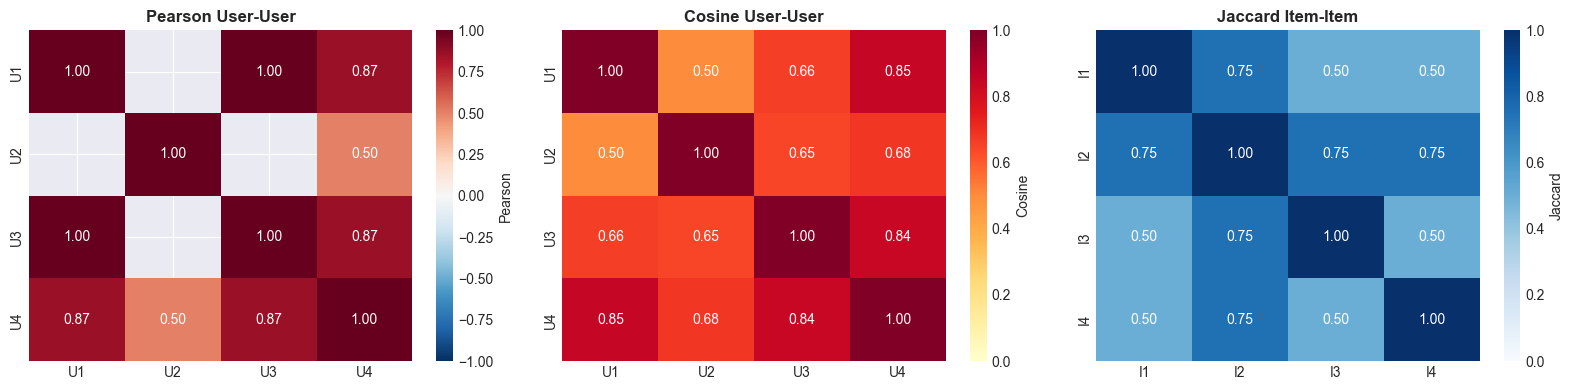


✅ Bài 1.2 hoàn thành!


In [5]:
print_section("BÀI 1.2: PEARSON, COSINE, JACCARD")

# ============ PEARSON USER-USER ============
def calc_pearson_matrix(ratings):
    """Tính Pearson correlation giữa users trên co-rated items"""
    users = ratings.index.tolist()
    pearson_mat = pd.DataFrame(index=users, columns=users, dtype=float)
    
    for u in users:
        for v in users:
            if u == v:
                pearson_mat.loc[u, v] = 1.0
            else:
                pair = ratings.loc[[u, v]].dropna(axis=1)
                
                # Trường hợp: không đủ co-rated items
                if pair.shape[1] < 2:
                    pearson_mat.loc[u, v] = np.nan
                else:
                    r, _ = safe_pearsonr(pair.iloc[0].values, pair.iloc[1].values)
                    pearson_mat.loc[u, v] = r
    
    return pearson_mat

pearson_mat = calc_pearson_matrix(ratings)
print("Pearson User-User Correlation:")
print(pearson_mat.round(3))

# ============ COSINE SIMILARITY (Fillna=0) ============
def calc_cosine_matrix(ratings, fill_method='zero'):
    """
    Tính Cosine similarity
    fill_method: 'zero' (NaN→0), 'mean' (NaN→user mean)
    """
    df = ratings.copy()
    
    if fill_method == 'zero':
        df = df.fillna(0)
    elif fill_method == 'mean':
        for u in df.index:
            mean_val = df.loc[u].mean()
            df.loc[u] = df.loc[u].fillna(mean_val)
    
    cosine_mat = pd.DataFrame(
        cosine_similarity(df),
        index=df.index, columns=df.index
    )
    return cosine_mat

print("\n" + "="*60)
print("Cosine Similarity (NaN→0):")
print("="*60)
cosine_mat_zero = calc_cosine_matrix(ratings, fill_method='zero')
print(cosine_mat_zero.round(3))

print("\n" + "="*60)
print("Cosine Similarity (NaN→User Mean):")
print("="*60)
cosine_mat_mean = calc_cosine_matrix(ratings, fill_method='mean')
print(cosine_mat_mean.round(3))

# ============ JACCARD ITEM-ITEM (binary watched) ============
def calc_jaccard_matrix(ratings):
    """Tính Jaccard similarity giữa items dựa trên watched set"""
    watched = ratings.notna().astype(int)
    items = ratings.columns.tolist()
    jaccard_mat = pd.DataFrame(index=items, columns=items, dtype=float)
    
    for i in items:
        for j in items:
            a = set(watched.index[watched[i] == 1])
            b = set(watched.index[watched[j] == 1])
            
            inter = len(a & b)
            union = len(a | b)
            
            # Trường hợp: cả 2 không ai xem
            jaccard_mat.loc[i, j] = inter / union if union > 0 else 0
    
    return jaccard_mat

print("\n" + "="*60)
print("Jaccard Item-Item Similarity (Binary Watched):")
print("="*60)
jaccard_mat = calc_jaccard_matrix(ratings)
print(jaccard_mat.round(3))

# ============ VISUALIZATION ============
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.heatmap(pearson_mat.astype(float), annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[0], cbar_kws={'label': 'Pearson'}, vmin=-1, vmax=1)
axes[0].set_title('Pearson User-User', fontsize=12, fontweight='bold')

sns.heatmap(cosine_mat_zero.astype(float), annot=True, fmt='.2f', cmap='YlOrRd',
            ax=axes[1], cbar_kws={'label': 'Cosine'}, vmin=0, vmax=1)
axes[1].set_title('Cosine User-User', fontsize=12, fontweight='bold')

sns.heatmap(jaccard_mat.astype(float), annot=True, fmt='.2f', cmap='Blues',
            ax=axes[2], cbar_kws={'label': 'Jaccard'}, vmin=0, vmax=1)
axes[2].set_title('Jaccard Item-Item', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Bài 1.2 hoàn thành!")

# CELL 5: BÀI 2.1 - WEIGHTED RATING (IMDB)


🔹 BÀI 2.1: WEIGHTED RATING (IMDB STYLE)

📊 Mean rating (C): 7.78
📊 Vote threshold (m, 60.0%): 105

📋 Quantile = 0.60:
title   v   R       WR
    A 120 7.2 7.468333
    C 300 6.9 7.126852

📋 Quantile = 0.25 (Low threshold):
📊 Mean rating (C): 7.78
📊 Vote threshold (m, 25.0%): 38
title   v   R       WR
    B  45 8.0 7.897727
    A 120 7.2 7.336905
    C 300 6.9 6.997222

📋 Quantile = 0.95 (High threshold):
📊 Mean rating (C): 7.78
📊 Vote threshold (m, 95.0%): 273
title   v   R       WR
    C 300 6.9 7.316885
📊 Mean rating (C): 7.78
📊 Vote threshold (m, 60.0%): 105


KeyError: "['B', 'D'] not in index"

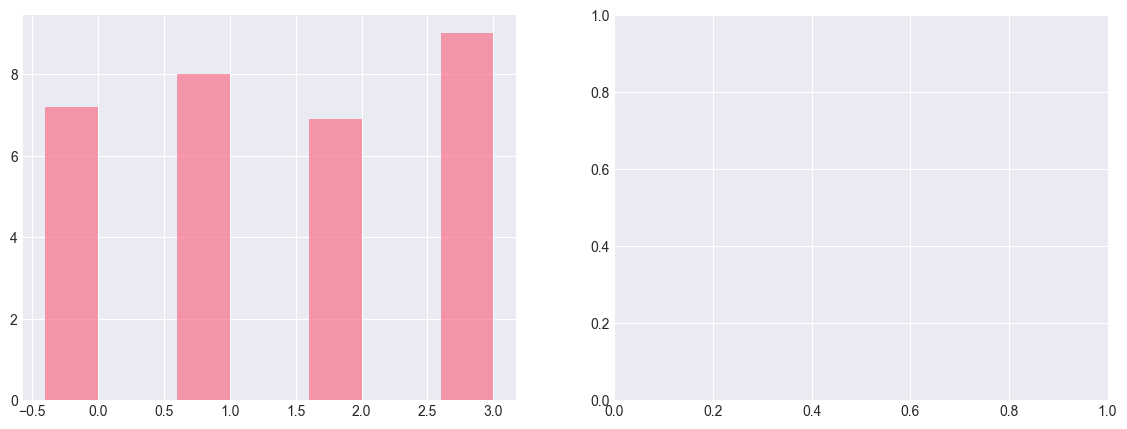

In [6]:
print_section("BÀI 2.1: WEIGHTED RATING (IMDB STYLE)")

def calc_weighted_rating(movies_df, quantile=0.60):
    """
    Tính Weighted Rating dùng công thức IMDB
    WR = (v/(v+m)) * R + (m/(v+m)) * C
    
    Args:
        movies_df: DataFrame với ['title', 'v', 'R']
        quantile: percentile cho m
    """
    C = movies_df['R'].mean()  # trung bình rating
    m = movies_df['v'].quantile(quantile)  # vote count threshold
    
    print(f"📊 Mean rating (C): {C:.2f}")
    print(f"📊 Vote threshold (m, {quantile*100}%): {m:.0f}")
    
    qualified = movies_df[movies_df['v'] >= m].copy()
    
    if qualified.empty:
        print("⚠️  Không có phim đủ tiêu chí!")
        return qualified
    
    qualified['WR'] = (qualified['v'] / (qualified['v'] + m)) * qualified['R'] + \
                      (m / (qualified['v'] + m)) * C
    
    return qualified.sort_values('WR', ascending=False)

# ============ TRƯỜNG HỢP 1: Quantile = 0.60 ============
result_60 = calc_weighted_rating(movies_df, quantile=0.60)
print("\n📋 Quantile = 0.60:")
print(result_60[['title', 'v', 'R', 'WR']].to_string(index=False))

# ============ TRƯỜNG HỢP 2: Quantile = 0.25 (thấp hơn) ============
print("\n" + "="*60)
print("📋 Quantile = 0.25 (Low threshold):")
print("="*60)
result_25 = calc_weighted_rating(movies_df, quantile=0.25)
print(result_25[['title', 'v', 'R', 'WR']].to_string(index=False))

# ============ TRƯỜNG HỢP 3: Quantile = 0.95 (cao hơn) ============
print("\n" + "="*60)
print("📋 Quantile = 0.95 (High threshold):")
print("="*60)
result_95 = calc_weighted_rating(movies_df, quantile=0.95)
print(result_95[['title', 'v', 'R', 'WR']].to_string(index=False))

# ============ VISUALIZATION ============
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Rating so sánh
ax1 = axes[0]
x_pos = np.arange(len(movies_df))
ax1.bar(x_pos - 0.2, movies_df['R'], width=0.4, label='Raw R', alpha=0.7)
wr_vals = calc_weighted_rating(movies_df, 0.60)[['title', 'WR']].set_index('title').loc[movies_df['title'], 'WR']
ax1.bar(x_pos + 0.2, wr_vals, width=0.4, label='Weighted R', alpha=0.7)
ax1.set_xlabel('Movie')
ax1.set_ylabel('Rating')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(movies_df['title'])
ax1.legend()
ax1.set_title('Raw Rating vs Weighted Rating', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Scatter: Vote count vs Rating
ax2 = axes[1]
ax2.scatter(movies_df['v'], movies_df['R'], s=300, alpha=0.6, c=range(len(movies_df)), cmap='viridis')
for idx, row in movies_df.iterrows():
    ax2.annotate(row['title'], (row['v'], row['R']), fontsize=11, fontweight='bold')
m_threshold = movies_df['v'].quantile(0.60)
ax2.axvline(m_threshold, color='red', linestyle='--', label=f'Threshold (m={m_threshold:.0f})', linewidth=2)
ax2.set_xlabel('Vote Count (v)')
ax2.set_ylabel('Average Rating (R)')
ax2.set_title('Vote Distribution', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Bài 2.1 hoàn thành!")

# CELL 7: BÀI 3.2 - ITEM-BASED COLLABORATIVE FILTERING


🔹 BÀI 3.2: ITEM-BASED CF - DỰ ĐOÁN RATING

🎯 Predicting r(U2, I4)

  User mean(U1) = 3.67
  User mean(U2) = 3.67
  User mean(U3) = 4.33
  User mean(U4) = 2.00

📊 Adjusted Cosine (mean-centered):
       I1     I2     I3     I4
I1  1.000  0.211 -0.868  0.120
I2  0.211  1.000 -0.400 -0.819
I3 -0.868 -0.400  1.000 -0.130
I4  0.120 -0.819 -0.130  1.000

📝 Items rated by U2: ['I1', 'I2', 'I3']
   Ratings: [3. 3. 5.]

  I1: sim(I4, I1) = 0.120, r(U2, I1) = 3.0
  I2: sim(I4, I2) = -0.819, r(U2, I2) = 3.0
  I3: sim(I4, I3) = -0.130, r(U2, I3) = 5.0

🎯 Top-2 similar items:
  I2: sim=-0.819, rating=3.0
  I3: sim=-0.130, rating=5.0

📈 Calculation:
  numerator = -3.105
  denominator = 0.949
  predicted rating = -3.273

✅ Predicted rating: -3.273


🔹 TRƯỜNG HỢP 2: r(U1, I3), k=2

🎯 Predicting r(U1, I3)

  User mean(U1) = 3.67
  User mean(U2) = 3.67
  User mean(U3) = 4.33
  User mean(U4) = 2.00

📊 Adjusted Cosine (mean-centered):
       I1     I2     I3     I4
I1  1.000  0.211 -0.868  0.120
I2  0.21

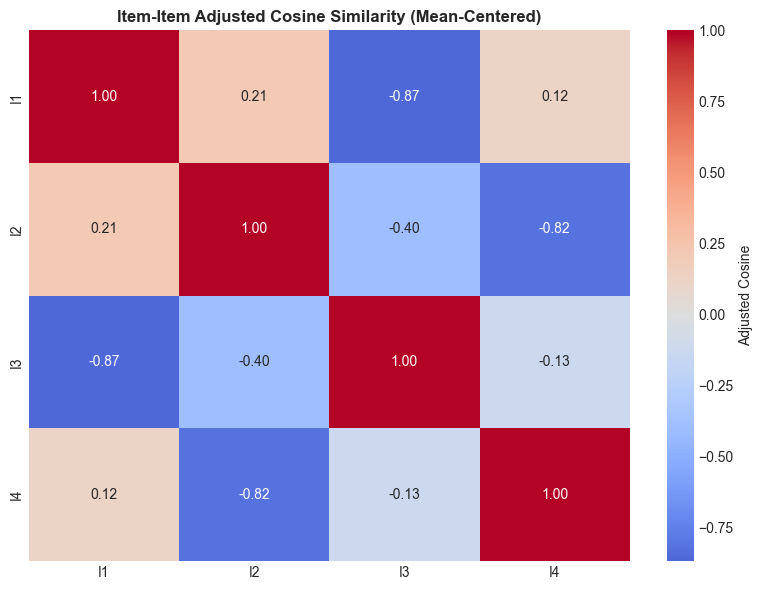

✅ Bài 3.2 hoàn thành!


In [7]:
print_section("BÀI 3.2: ITEM-BASED CF - DỰ ĐOÁN RATING")

def item_based_cf_predict(ratings, target_user, target_item, k=2):
    """
    Dự đoán rating dùng Item-based CF (Adjusted Cosine)
    
    Args:
        ratings: DataFrame (user × item)
        target_user: tên user
        target_item: tên item
        k: số item neighbors
    
    Returns:
        dict với chi tiết
    """
    print(f"🎯 Predicting r({target_user}, {target_item})\n")
    
    # Bước 1: Mean-center theo user
    df = ratings.copy()
    for u in ratings.index:
        mu = np.nanmean(df.loc[u].values)
        df.loc[u] = df.loc[u] - mu
        print(f"  User mean({u}) = {mu:.2f}")
    
    print()
    
    # Bước 2: Tính Adjusted Cosine similarity
    centered = df.fillna(0)
    item_cos = pd.DataFrame(
        cosine_similarity(centered.T),
        index=centered.columns, columns=centered.columns
    )
    
    print("📊 Adjusted Cosine (mean-centered):")
    print(item_cos.round(3))
    print()
    
    # Bước 3: Tìm rated items bởi target_user
    rated_items = ratings.columns[ratings.loc[target_user].notna()].tolist()
    print(f"📝 Items rated by {target_user}: {rated_items}")
    print(f"   Ratings: {ratings.loc[target_user, rated_items].values}\n")
    
    # Bước 4: Tính similarity với target_item
    sims = []
    for i in rated_items:
        if i == target_item:
            continue
        
        sim = item_cos.loc[target_item, i]
        rating = ratings.loc[target_user, i]
        sims.append((i, sim, rating))
        print(f"  {i}: sim({target_item}, {i}) = {sim:.3f}, r({target_user}, {i}) = {rating}")
    
    print()
    
    if not sims:
        print("⚠️  Không có item nào để tính!")
        return {'prediction': np.nan, 'neighbors': []}
    
    # Bước 5: Chọn top-k
    sims.sort(key=lambda x: -abs(x[1]))
    top_k = sims[:min(k, len(sims))]
    
    print(f"🎯 Top-{len(top_k)} similar items:")
    for i, sim, rating in top_k:
        print(f"  {i}: sim={sim:.3f}, rating={rating}")
    
    print()
    
    # Bước 6: Tính predicted rating (weighted average)
    num, den = 0.0, 0.0
    for i, w, rating in top_k:
        num += rating * w
        den += abs(w)
    
    pred = num / den if den != 0 else np.nan
    
    print(f"📈 Calculation:")
    print(f"  numerator = {num:.3f}")
    print(f"  denominator = {den:.3f}")
    print(f"  predicted rating = {pred:.3f}")
    
    return {
        'prediction': pred,
        'neighbors': top_k,
        'item_cos': item_cos
    }

# ============ TRƯỜNG HỢP 1: r(U2, I4) ============
result_item_1 = item_based_cf_predict(ratings, 'U2', 'I4', k=2)
print(f"\n✅ Predicted rating: {result_item_1['prediction']:.3f}\n")

# ============ TRƯỜNG HỢP 2: r(U1, I3) ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: r(U1, I3), k=2")
print("="*60 + "\n")
result_item_2 = item_based_cf_predict(ratings, 'U1', 'I3', k=2)
print(f"\n✅ Predicted rating: {result_item_2['prediction']:.3f}\n")

# ============ VISUALIZATION: Item Similarity Heatmap ============
plt.figure(figsize=(8, 6))
sns.heatmap(result_item_1['item_cos'], annot=True, fmt='.2f', cmap='coolwarm',
            center=0, cbar_kws={'label': 'Adjusted Cosine'})
plt.title('Item-Item Adjusted Cosine Similarity (Mean-Centered)', fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Bài 3.2 hoàn thành!")

# CELL 8: BÀI 3.3 - KNN RECOMMENDATION

In [8]:
print_section("BÀI 3.3: KNN USER-USER - TOP-N RECOMMENDATIONS")

def knn_recommend(ratings, target_user, n_neighbors=3, top_n=5):
    """
    Dùng KNN (cosine) để recommend top-N phim mới
    """
    mat = ratings.fillna(0).values
    knn_model = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=n_neighbors+1)
    knn_model.fit(mat)
    
    u_idx = ratings.index.get_loc(target_user)
    dists, idxs = knn_model.kneighbors([mat[u_idx]], return_distance=True)
    
    print(f"🔍 Finding {n_neighbors} nearest neighbors to {target_user}:\n")
    
    neighbors_info = []
    for i, idx in enumerate(idxs[0]):
        neighbor_user = ratings.index[idx]
        distance = dists[0][i]
        similarity = 1 - distance  # cosine distance → similarity
        neighbors_info.append((neighbor_user, similarity))
        
        if i == 0:
            print(f"  {i}. {neighbor_user}: distance={distance:.4f}, sim={similarity:.4f} [SELF]")
        else:
            print(f"  {i}. {neighbor_user}: distance={distance:.4f}, sim={similarity:.4f}")
    
    print()
    
    # Bỏ chính target_user
    neighbors = [n for n, _ in neighbors_info[1:]]
    
    # Tìm phim mới để recommend
    target_watched = set(ratings.columns[ratings.loc[target_user].notna()])
    
    scores = {}
    for neighbor in neighbors:
        neighbor_ratings = ratings.loc[neighbor]
        
        # Tìm phim neighbor đã xem nhưng target_user chưa
        for item, rating in neighbor_ratings.items():
            if pd.isna(rating) or item in target_watched:
                continue
            
            if item not in scores:
                scores[item] = []
            scores[item].append(float(rating))
    
    if not scores:
        print("⚠️  Không tìm được phim mới để recommend!")
        return []
    
    # Tính trung bình
    ranked = sorted(
        ((item, np.mean(rs)) for item, rs in scores.items()),
        key=lambda x: -x[1]
    )
    
    print(f"📝 Target user {target_user} watched: {target_watched}")
    print(f"📚 Candidates from neighbors: {list(scores.keys())}\n")
    
    print(f"🎬 Top-{min(top_n, len(ranked))} Recommendations:")
    for rank, (item, score) in enumerate(ranked[:top_n], 1):
        print(f"  {rank}. {item}: avg_score={score:.2f}")
    
    return ranked[:top_n]

# ============ TRƯỜNG HỢP 1: Top-5 cho U1 với 3 neighbors ============
recs_u1 = knn_recommend(ratings, 'U1', n_neighbors=3, top_n=5)
print()

# ============ TRƯỜNG HỢP 2: Top-3 cho U2 với 2 neighbors ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: Top-3 recommendations cho U2")
print("="*60 + "\n")
recs_u2 = knn_recommend(ratings, 'U2', n_neighbors=2, top_n=3)
print()

# ============ VISUALIZATION ============
if recs_u1:
    plt.figure(figsize=(10, 5))
    items, scores = zip(*recs_u1)
    colors = plt.cm.viridis(normalize_scores(scores))
    bars = plt.barh(items, scores, color=colors)
    plt.xlabel('Predicted Score', fontsize=12)
    plt.title('Top-N Recommendations for U1 (KNN)', fontweight='bold', fontsize=13)
    
    # Thêm giá trị trên bar
    for i, (bar, score) in enumerate(zip(bars, scores)):
        plt.text(score + 0.05, i, f'{score:.2f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("✅ Bài 3.3 hoàn thành!")


🔹 BÀI 3.3: KNN USER-USER - TOP-N RECOMMENDATIONS

🔍 Finding 3 nearest neighbors to U1:

  0. U1: distance=0.0000, sim=1.0000 [SELF]
  1. U4: distance=0.1534, sim=0.8466
  2. U3: distance=0.3381, sim=0.6619
  3. U2: distance=0.4999, sim=0.5001

📝 Target user U1 watched: {'I1', 'I2', 'I4'}
📚 Candidates from neighbors: ['I3']

🎬 Top-1 Recommendations:
  1. I3: avg_score=3.67


🔹 TRƯỜNG HỢP 2: Top-3 recommendations cho U2

🔍 Finding 2 nearest neighbors to U2:

  0. U2: distance=0.0000, sim=1.0000 [SELF]
  1. U4: distance=0.3171, sim=0.6829
  2. U3: distance=0.3536, sim=0.6464

📝 Target user U2 watched: {'I1', 'I2', 'I3'}
📚 Candidates from neighbors: ['I4']

🎬 Top-1 Recommendations:
  1. I4: avg_score=4.00



AttributeError: 'tuple' object has no attribute 'values'

<Figure size 1000x500 with 0 Axes>

# CELL 9: BÀI 4.1 - ONE-HOT ENCODING GENRES


🔹 BÀI 4.1: ONE-HOT GENRE MATRIX

📊 Genre One-Hot Matrix:
genre  Action  Adventure  Comedy  Drama  Sci-Fi
title                                          
A           1          1       0      0       0
B           0          0       0      1       0
C           1          0       0      0       1
D           0          0       1      1       0



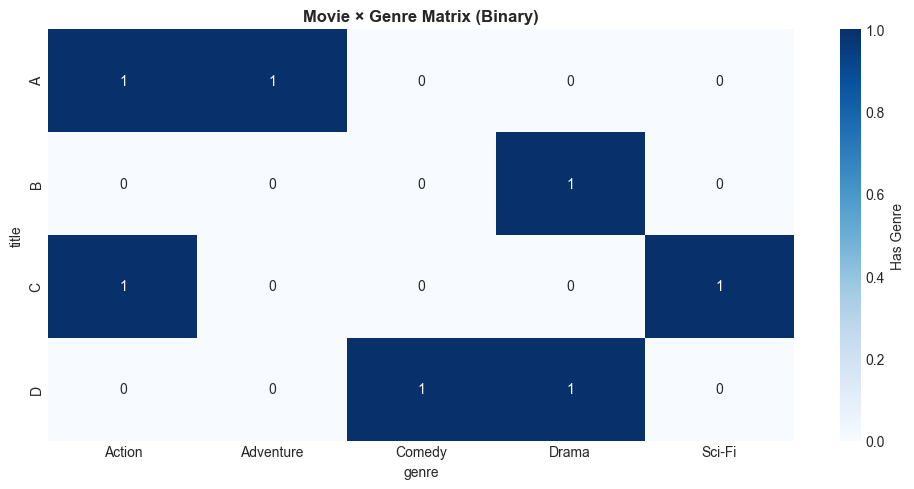

✅ Bài 4.1 hoàn thành!


In [9]:
print_section("BÀI 4.1: ONE-HOT GENRE MATRIX")

def genre_matrix(movies_df):
    """Tạo ma trận genre binary"""
    rows = []
    for _, row in movies_df.iterrows():
        for g in row['genres'].split('|'):
            rows.append({'title': row['title'], 'genre': g.strip()})
    
    genre_df = pd.DataFrame(rows)
    cross = pd.crosstab(genre_df['title'], genre_df['genre'])
    return cross

genre_mat = genre_matrix(movies_df)
print("📊 Genre One-Hot Matrix:")
print(genre_mat)
print()

# ============ VISUALIZATION ============
plt.figure(figsize=(10, 5))
sns.heatmap(genre_mat, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Has Genre'})
plt.title('Movie × Genre Matrix (Binary)', fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Bài 4.1 hoàn thành!")

# CELL 10: BÀI 4.2 - TF-IDF SIMILARITY


🔹 BÀI 4.2: TF-IDF + COSINE - TÌM PHIM TƯƠNG TỰ

🔤 TF-IDF Features (genres): ['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi']
📊 Term Frequency-Inverse Document Frequency matrix shape: (4, 5)

📈 Cosine Similarity Matrix:
title      A      B      C      D
title                            
A      1.000  0.000  0.383  0.000
B      0.000  1.000  0.000  0.619
C      0.383  0.000  1.000  0.000
D      0.000  0.619  0.000  1.000

🎬 Top-3 movies similar to 'A':
  1. C: similarity=0.383
  2. B: similarity=0.000
  3. D: similarity=0.000


🔹 TRƯỜNG HỢP 2: Similar movies to 'B'

🔤 TF-IDF Features (genres): ['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi']
📊 Term Frequency-Inverse Document Frequency matrix shape: (4, 5)

📈 Cosine Similarity Matrix:
title      A      B      C      D
title                            
A      1.000  0.000  0.383  0.000
B      0.000  1.000  0.000  0.619
C      0.383  0.000  1.000  0.000
D      0.000  0.619  0.000  1.000

🎬 Top-3 movies similar to 'B':
  1. D: simil

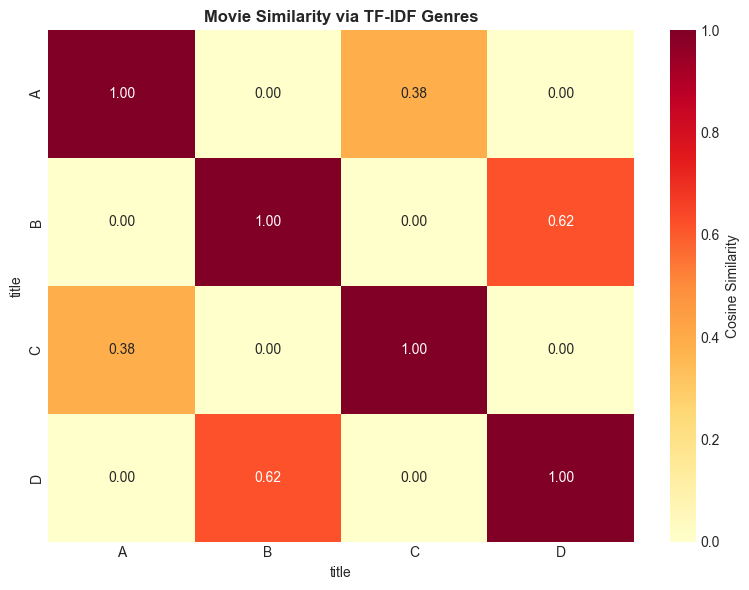

✅ Bài 4.2 hoàn thành!


In [10]:
print_section("BÀI 4.2: TF-IDF + COSINE - TÌM PHIM TƯƠNG TỰ")

def tfidf_similarity(movies_df, target_movie, top_n=5):
    """TF-IDF tìm phim tương tự"""
    corpus = movies_df['genres'].fillna('')
    vec = TfidfVectorizer(token_pattern=r"[^|]+", lowercase=False)
    X = vec.fit_transform(corpus)
    
    print(f"🔤 TF-IDF Features (genres): {vec.get_feature_names_out().tolist()}")
    print(f"📊 Term Frequency-Inverse Document Frequency matrix shape: {X.shape}\n")
    
    # Tính similarity
    sim = cosine_similarity(X)
    sim_df = pd.DataFrame(sim, index=movies_df['title'], columns=movies_df['title'])
    
    print("📈 Cosine Similarity Matrix:")
    print(sim_df.round(3))
    print()
    
    # Tìm phim similar
    similar = sim_df.loc[target_movie].sort_values(ascending=False).iloc[1:top_n+1]
    
    print(f"🎬 Top-{len(similar)} movies similar to '{target_movie}':")
    for rank, (movie, sim_score) in enumerate(similar.items(), 1):
        print(f"  {rank}. {movie}: similarity={sim_score:.3f}")
    
    return list(zip(similar.index, similar.values))

# ============ TRƯỜNG HỢP 1: Tìm phim similar với A ============
similar_a = tfidf_similarity(movies_df, 'A', top_n=5)
print()

# ============ TRƯỜNG HỢP 2: Tìm phim similar với B ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: Similar movies to 'B'")
print("="*60 + "\n")
similar_b = tfidf_similarity(movies_df, 'B', top_n=5)
print()

# ============ VISUALIZATION ============
vec = TfidfVectorizer(token_pattern=r"[^|]+", lowercase=False)
X = vec.fit_transform(movies_df['genres'].fillna(''))
sim_mat = cosine_similarity(X)
sim_df = pd.DataFrame(sim_mat, index=movies_df['title'], columns=movies_df['title'])

plt.figure(figsize=(8, 6))
sns.heatmap(sim_df, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Cosine Similarity'})
plt.title('Movie Similarity via TF-IDF Genres', fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Bài 4.2 hoàn thành!")

# CELL 11: BÀI 4.3 - RIDGE REGRESSION CONTENT-BASED


🔹 BÀI 4.3: RIDGE REGRESSION - CONTENT-BASED

📊 Feature space dimension: 5
📝 User ratings:
A    5
B    2
D    4
dtype: int64

📚 Training samples: 3
   y_train: [5 2 4]

📈 Ridge coefficient (alpha=1.0): [ 0.37414601  0.47455677  0.33141269 -0.76504622  0.        ]
   Intercept: 3.791

🎬 Predictions for all movies:
  A: 4.396 ✓ (TRAIN)
  C: 4.023 
  D: 3.578 ✓ (TRAIN)
  B: 3.026 ✓ (TRAIN)


🔹 TRƯỜNG HỢP 2: IMPACT CỦA ALPHA (REGULARIZATION)

📊 Feature space dimension: 5
📝 User ratings:
A    5
B    2
D    4
dtype: int64

📚 Training samples: 3
   y_train: [5 2 4]

📈 Ridge coefficient (alpha=0.1): [ 0.63190581  0.80149239  1.23231214 -1.61831366  0.        ]
   Intercept: 3.877

🎬 Predictions for all movies:
  A: 4.898 ✓ (TRAIN)
  C: 4.269 
  D: 3.843 ✓ (TRAIN)
  B: 2.259 ✓ (TRAIN)

📊 Feature space dimension: 5
📝 User ratings:
A    5
B    2
D    4
dtype: int64

📚 Training samples: 3
   y_train: [5 2 4]

📈 Ridge coefficient (alpha=1.0): [ 0.37414601  0.47455677  0.33141269 -0.76504622  0.    

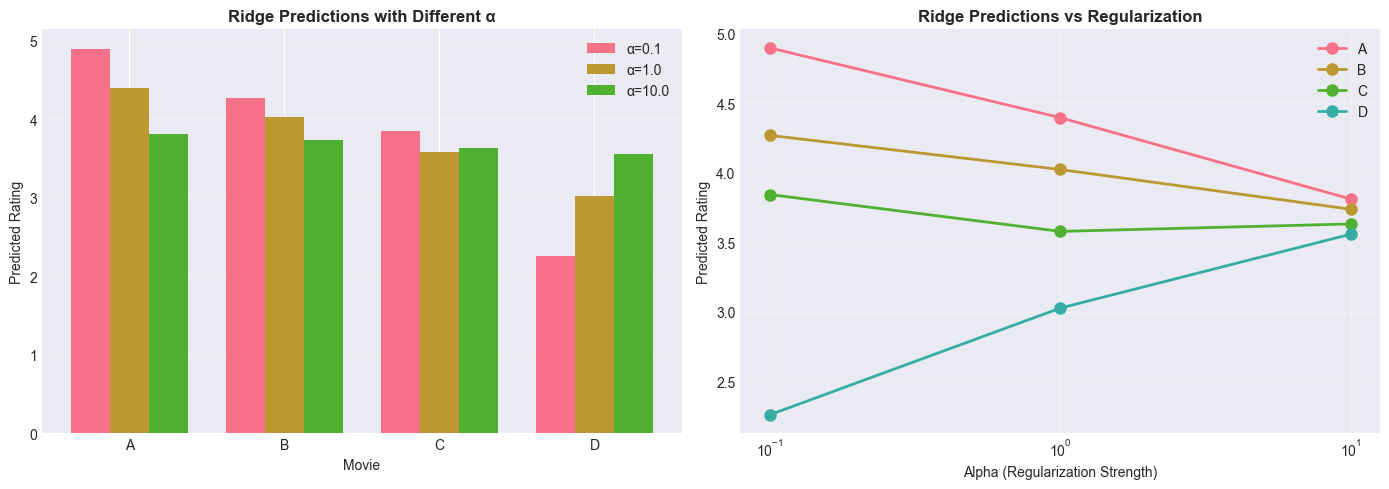

✅ Bài 4.3 hoàn thành!


In [11]:
print_section("BÀI 4.3: RIDGE REGRESSION - CONTENT-BASED")

def ridge_content_predict(movies_df, user_ratings, alpha=1.0):
    """
    Ridge Regression học hồ sơ user từ TF-IDF
    
    Args:
        movies_df: DataFrame ['title', 'genres']
        user_ratings: Series {title: rating, ...}
        alpha: regularization strength
    """
    corpus = movies_df['genres'].fillna('')
    vec = TfidfVectorizer(token_pattern=r"[^|]+", lowercase=False)
    X = vec.fit_transform(corpus)
    
    print(f"📊 Feature space dimension: {X.shape[1]}")
    print(f"📝 User ratings:\n{user_ratings}\n")
    
    # Train set
    mask = movies_df['title'].isin(user_ratings.index)
    X_train = X[mask]
    y_train = user_ratings.loc[movies_df.loc[mask, 'title']].values
    
    print(f"📚 Training samples: {X_train.shape[0]}")
    print(f"   y_train: {y_train}\n")
    
    # Fit Ridge
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    print(f"📈 Ridge coefficient (alpha={alpha}): {model.coef_}")
    print(f"   Intercept: {model.intercept_:.3f}\n")
    
    # Predict all
    preds = model.predict(X)
    result = pd.Series(preds, index=movies_df['title']).sort_values(ascending=False)
    
    print(f"🎬 Predictions for all movies:")
    for movie, score in result.items():
        is_train = "✓ (TRAIN)" if movie in user_ratings.index else ""
        print(f"  {movie}: {score:.3f} {is_train}")
    
    return result, model

# ============ TRƯỜNG HỢP 1: User U_x với ratings {A:5, B:2, D:4} ============
user_x_ratings = pd.Series({'A': 5, 'B': 2, 'D': 4})
preds_1, model_1 = ridge_content_predict(movies_df, user_x_ratings, alpha=1.0)
print()

# ============ TRƯỜNG HỢP 2: So sánh alpha khác nhau ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: IMPACT CỦA ALPHA (REGULARIZATION)")
print("="*60 + "\n")

alpha_values = [0.1, 1.0, 10.0]
all_preds = {}

for alpha in alpha_values:
    preds, _ = ridge_content_predict(movies_df, user_x_ratings, alpha=alpha)
    all_preds[alpha] = preds.values
    print()

# Visualization: So sánh alpha
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
x_pos = np.arange(len(movies_df))
width = 0.25

for i, alpha in enumerate(alpha_values):
    ax1.bar(x_pos + i*width, all_preds[alpha], width, label=f'α={alpha}')

ax1.set_xlabel('Movie')
ax1.set_ylabel('Predicted Rating')
ax1.set_title('Ridge Predictions with Different α', fontweight='bold')
ax1.set_xticks(x_pos + width)
ax1.set_xticklabels(movies_df['title'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Line plot: Thay đổi theo alpha
ax2 = axes[1]
for i, movie in enumerate(movies_df['title']):
    scores = [all_preds[alpha][i] for alpha in alpha_values]
    ax2.plot(alpha_values, scores, marker='o', label=movie, linewidth=2, markersize=8)

ax2.set_xlabel('Alpha (Regularization Strength)')
ax2.set_ylabel('Predicted Rating')
ax2.set_title('Ridge Predictions vs Regularization', fontweight='bold')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Bài 4.3 hoàn thành!")

# CELL 12: BÀI 5.1 - SVD MATRIX FACTORIZATION

In [12]:
print_section("BÀI 5.1: SVD - MATRIX FACTORIZATION & RECONSTRUCTION")

def svd_reconstruct(ratings, k=2):
    """SVD phân rã và khôi phục"""
    M = ratings.fillna(0).values
    print(f"📊 Original matrix shape: {M.shape}")
    print(f"📊 Sparsity: {ratings.isna().sum().sum() / ratings.size * 100:.1f}%\n")
    
    U, S, VT = svd(M, full_matrices=False)
    
    print(f"📐 SVD Decomposition:")
    print(f"  U shape: {U.shape} (user factors)")
    print(f"  S shape: {S.shape} (singular values)")
    print(f"  VT shape: {VT.shape} (item factors)")
    print(f"\n📊 Singular values: {S}")
    print(f"   Explained variance ratio: {(S**2 / np.sum(S**2))}")
    print(f"   Cumulative explained: {np.cumsum(S**2 / np.sum(S**2))}\n")
    
    # Khôi phục với k thành phần
    Mk = (U[:, :k] * S[:k]) @ VT[:k, :]
    M_reconstructed = pd.DataFrame(
        Mk, index=ratings.index, columns=ratings.columns
    )
    
    print(f"🔄 Reconstructed with k={k} components:")
    print(M_reconstructed.round(2))
    
    # Tính reconstruction error (chỉ trên observed entries)
    observed = ratings.notna()
    diff = (ratings.fillna(0) - M_reconstructed) * observed
    rmse = np.sqrt(np.sum(diff**2) / observed.sum().sum())
    print(f"\n📈 Reconstruction RMSE (observed only): {rmse:.4f}")
    
    return M_reconstructed

# ============ TRƯỜNG HỢP 1: k=2 ============
M_hat_k2 = svd_reconstruct(ratings, k=2)
print()

# ============ TRƯỜNG HỢP 2: k=3 ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: k=3")
print("="*60 + "\n")
M_hat_k3 = svd_reconstruct(ratings, k=3)
print()

# ============ TRƯỜNG HỢP 3: So sánh k khác nhau ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 3: RMSE vs k")
print("="*60 + "\n")

k_range = range(1, ratings.shape[0] + 1)
rmses = []

for k in k_range:
    M = ratings.fillna(0).values
    U, S, VT = svd(M, full_matrices=False)
    Mk = (U[:, :k] * S[:k]) @ VT[:k, :]
    
    observed = ratings.notna()
    diff = (ratings.fillna(0) - Mk) * observed
    rmse = np.sqrt(np.sum(diff**2) / observed.sum().sum())
    rmses.append(rmse)
    print(f"  k={k}: RMSE={rmse:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Singular values
M = ratings.fillna(0).values
U, S, VT = svd(M, full_matrices=False)
ax1 = axes[0]
ax1.bar(range(len(S)), S, alpha=0.7, color='steelblue')
ax1.set_xlabel('Component Index')
ax1.set_ylabel('Singular Value')
ax1.set_title('Singular Values (S)', fontweight='bold')
ax1.grid(alpha=0.3)

# RMSE vs k
ax2 = axes[1]
ax2.plot(list(k_range), rmses, marker='o', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('k (number of components)')
ax2.set_ylabel('Reconstruction RMSE')
ax2.set_title('Reconstruction Error vs k', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Bài 5.1 hoàn thành!")


🔹 BÀI 5.1: SVD - MATRIX FACTORIZATION & RECONSTRUCTION

📊 Original matrix shape: (4, 4)
📊 Sparsity: 18.8%

📐 SVD Decomposition:
  U shape: (4, 4) (user factors)
  S shape: (4,) (singular values)
  VT shape: (4, 4) (item factors)

📊 Singular values: [10.99974443  4.63590629  3.8243245   1.37424073]
   Explained variance ratio: [0.76097093 0.13516747 0.09198401 0.01187759]
   Cumulative explained: [0.76097093 0.89613839 0.98812241 1.        ]

🔄 Reconstructed with k=2 components:
      I1    I2    I3    I4
U1  2.28  2.69  0.57  4.90
U2  1.61  2.93  5.38  0.64
U3  2.62  3.68  3.51  4.02
U4  1.55  2.08  1.59  2.66


TypeError: unsupported format string passed to Series.__format__

# CELL 13: BÀI 5.2 - MATRIX FACTORIZATION SGD


🔹 BÀI 5.2: MATRIX FACTORIZATION VỚI SGD

📊 Training data: 13 observations out of 16 (81.2%)

Epoch   1/500: loss=159.8564 (obs_loss=159.8527, reg_loss=0.0037)
Epoch 101/500: loss=0.7264 (obs_loss=0.0283, reg_loss=0.6982)
Epoch 201/500: loss=0.7158 (obs_loss=0.0202, reg_loss=0.6957)
Epoch 301/500: loss=0.7138 (obs_loss=0.0193, reg_loss=0.6944)
Epoch 401/500: loss=0.7159 (obs_loss=0.0223, reg_loss=0.6936)
Epoch 500/500: loss=0.7188 (obs_loss=0.0250, reg_loss=0.6939)

✅ Reconstructed matrix:
      I1    I2    I3    I4
U1  3.94  2.98  5.57  4.00
U2  3.03  3.00  4.95  2.91
U3  2.50  3.95  4.01  4.97
U4  2.00  1.05  1.99  2.95


🔹 TRƯỜNG HỢP 2: IMPACT CỦA LEARNING RATE

Training with lr=0.01...
📊 Training data: 13 observations out of 16 (81.2%)

  Final loss: 0.7449

Training with lr=0.05...
📊 Training data: 13 observations out of 16 (81.2%)

  Final loss: 0.7188

Training with lr=0.1...
📊 Training data: 13 observations out of 16 (81.2%)

  Final loss: 0.7226


🔹 TRƯỜNG HỢP 3: IMPACT CỦA RE

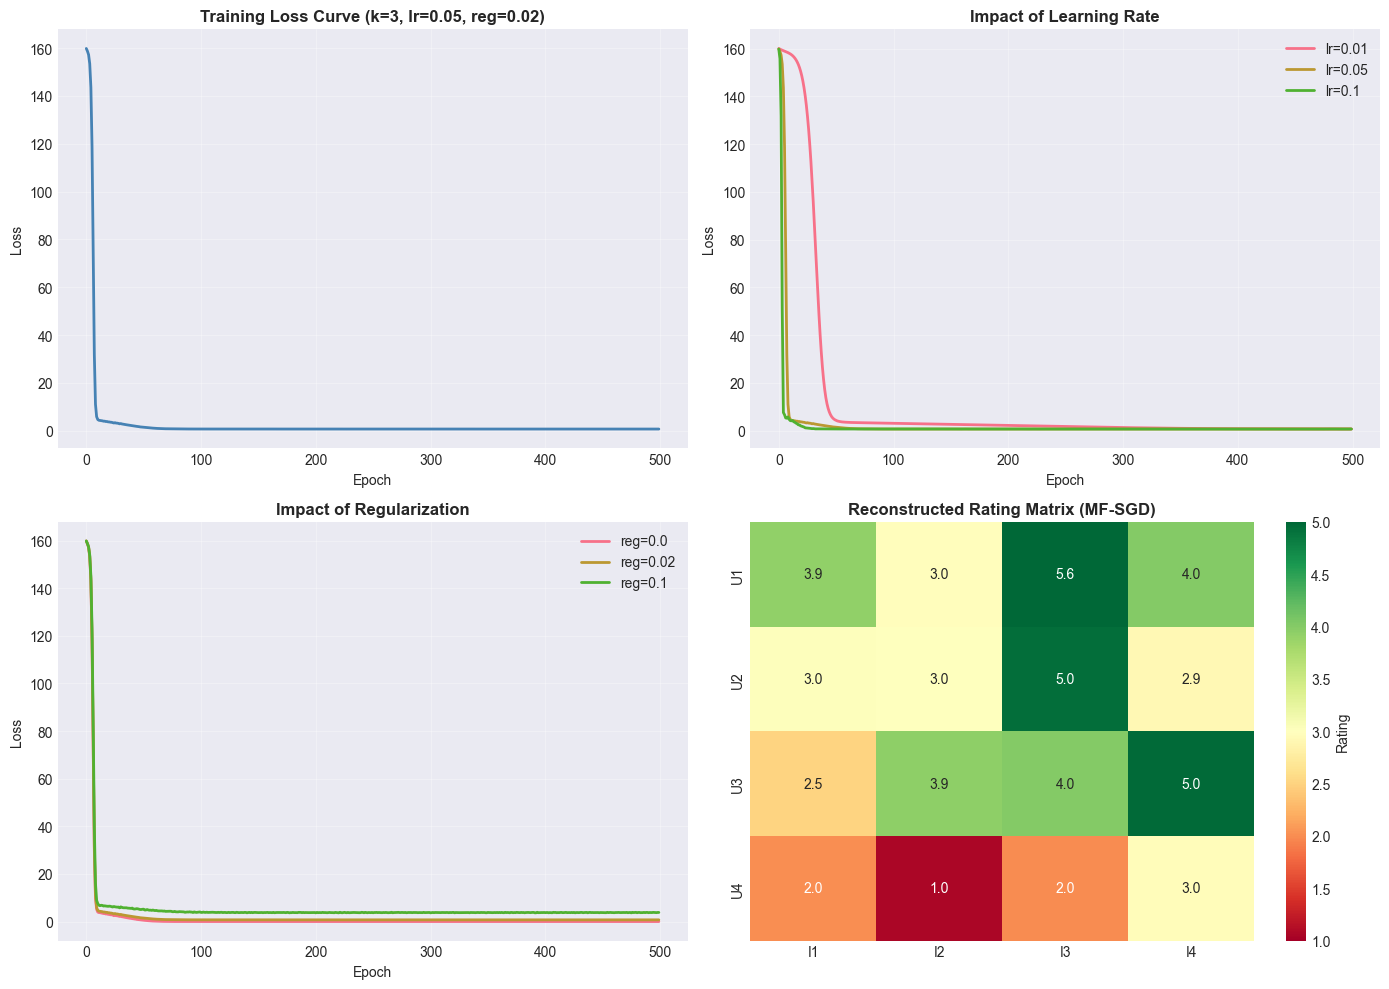

✅ Bài 5.2 hoàn thành!


In [13]:
print_section("BÀI 5.2: MATRIX FACTORIZATION VỚI SGD")

def mf_sgd_train(ratings, k=3, lr=0.05, reg=0.02, epochs=500, seed=0, verbose=True):
    """
    Matrix Factorization với SGD
    Phân rã R ≈ X·W (user_factors × item_factors)
    
    Args:
        ratings: DataFrame (user × item)
        k: số latent factors
        lr: learning rate
        reg: regularization coefficient
        epochs: số epoch
        seed: random seed
        verbose: in loss mỗi epoch
    
    Returns:
        dict {'model': R_hat, 'X': user_factors, 'W': item_factors, 'losses': loss_history}
    """
    np.random.seed(seed)
    R = ratings.copy()
    
    # Tập observations
    obs = [
        (i, j, R.iloc[i, j])
        for i in range(R.shape[0])
        for j in range(R.shape[1])
        if not pd.isna(R.iloc[i, j])
    ]
    
    n_users, n_items = R.shape
    print(f"📊 Training data: {len(obs)} observations out of {n_users*n_items} ({len(obs)/(n_users*n_items)*100:.1f}%)\n")
    
    # Initialize factors
    X = 0.1 * np.random.randn(n_users, k)  # user factors
    W = 0.1 * np.random.randn(k, n_items)  # item factors
    
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # Shuffle observations
        np.random.shuffle(obs)
        
        for i, j, r in obs:
            pred = X[i] @ W[:, j]
            err = r - pred
            epoch_loss += err**2
            
            # SGD updates
            X[i] += lr * (err * W[:, j] - reg * X[i])
            W[:, j] += lr * (err * X[i] - reg * W[:, j])
        
        # Regularization loss
        reg_loss = reg * (np.sum(X**2) + np.sum(W**2))
        total_loss = epoch_loss + reg_loss
        loss_history.append(total_loss)
        
        if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch+1:3d}/{epochs}: loss={total_loss:.4f} (obs_loss={epoch_loss:.4f}, reg_loss={reg_loss:.4f})")
    
    # Reconstruct
    R_hat = pd.DataFrame(X @ W, index=ratings.index, columns=ratings.columns)
    
    return {
        'R_hat': R_hat,
        'X': X,
        'W': W,
        'losses': loss_history
    }

# ============ TRƯỜNG HỢP 1: Training với default params ============
result_1 = mf_sgd_train(ratings, k=3, lr=0.05, reg=0.02, epochs=500, seed=42)
print(f"\n✅ Reconstructed matrix:")
print(result_1['R_hat'].round(2))
print()

# ============ TRƯỜNG HỢP 2: So sánh learning rates ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: IMPACT CỦA LEARNING RATE")
print("="*60 + "\n")

lrs = [0.01, 0.05, 0.1]
results_lr = {}

for lr in lrs:
    print(f"Training with lr={lr}...")
    results_lr[lr] = mf_sgd_train(ratings, k=3, lr=lr, reg=0.02, epochs=500, seed=42, verbose=False)
    print(f"  Final loss: {results_lr[lr]['losses'][-1]:.4f}\n")

# ============ TRƯỜNG HỢP 3: So sánh regularization ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 3: IMPACT CỦA REGULARIZATION")
print("="*60 + "\n")

regs = [0.0, 0.02, 0.1]
results_reg = {}

for reg in regs:
    print(f"Training with reg={reg}...")
    results_reg[reg] = mf_sgd_train(ratings, k=3, lr=0.05, reg=reg, epochs=500, seed=42, verbose=False)
    print(f"  Final loss: {results_reg[reg]['losses'][-1]:.4f}\n")

# ============ VISUALIZATION ============
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss history - main model
ax1 = axes[0, 0]
ax1.plot(result_1['losses'], linewidth=2, color='steelblue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve (k=3, lr=0.05, reg=0.02)', fontweight='bold')
ax1.grid(alpha=0.3)

# Learning rate comparison
ax2 = axes[0, 1]
for lr in lrs:
    ax2.plot(results_lr[lr]['losses'], label=f'lr={lr}', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Impact of Learning Rate', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Regularization comparison
ax3 = axes[1, 0]
for reg in regs:
    ax3.plot(results_reg[reg]['losses'], label=f'reg={reg}', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Impact of Regularization', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Final reconstructed matrix heatmap
ax4 = axes[1, 1]
sns.heatmap(result_1['R_hat'], annot=True, fmt='.1f', cmap='RdYlGn', ax=ax4,
            vmin=1, vmax=5, cbar_kws={'label': 'Rating'})
ax4.set_title('Reconstructed Rating Matrix (MF-SGD)', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Bài 5.2 hoàn thành!")

# CELL 14: BÀI 6.1 - CO-OCCURRENCE ANALYSIS


🔹 BÀI 6.1: CO-OCCURRENCE PAIRS - ITEMS WATCHED TOGETHER

📊 Co-occurrence pairs (items watched together):
I1  I2    3
I2  I4    3
    I3    3
I1  I4    2
    I3    2
I3  I4    2
dtype: int64



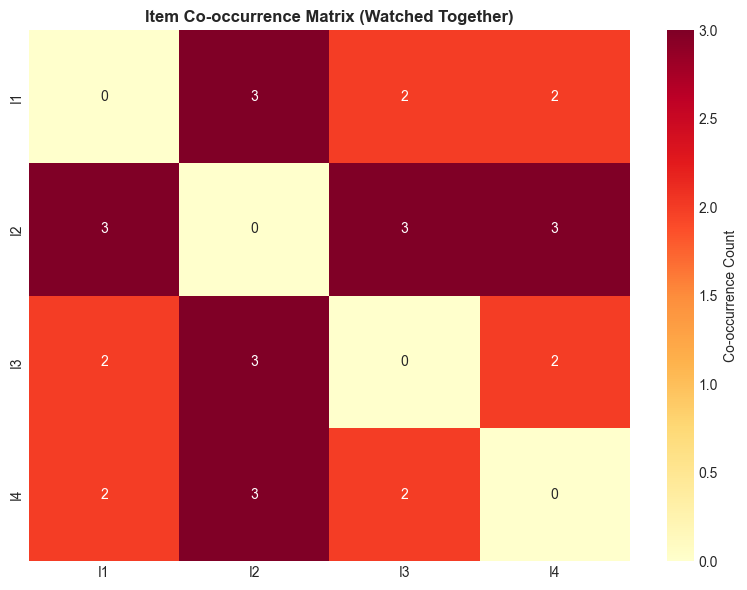

✅ Bài 6.1 hoàn thành!


In [14]:
print_section("BÀI 6.1: CO-OCCURRENCE PAIRS - ITEMS WATCHED TOGETHER")

def cooccurrence_analysis(ratings):
    """Đếm số lần hai phim xuất hiện cùng user"""
    watched = ratings.notna().astype(int)
    counts = {}
    
    # Đếm cặp
    for _, row in watched.iterrows():
        items = [c for c, v in row.items() if v == 1]
        for a, b in combinations(sorted(items), 2):
            counts[(a, b)] = counts.get((a, b), 0) + 1
    
    result = pd.Series(counts).sort_values(ascending=False)
    return result

cooc = cooccurrence_analysis(ratings)
print("📊 Co-occurrence pairs (items watched together):")
print(cooc)
print()

# ============ VISUALIZATION: Co-occurrence matrix ============
items = ratings.columns.tolist()
cooc_mat = pd.DataFrame(0, index=items, columns=items)

for (i, j), count in cooc.items():
    cooc_mat.loc[i, j] = count
    cooc_mat.loc[j, i] = count

plt.figure(figsize=(8, 6))
sns.heatmap(cooc_mat, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Item Co-occurrence Matrix (Watched Together)', fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Bài 6.1 hoàn thành!")

# CELL 15: BÀI 7.1 - RMSE EVALUATION


🔹 BÀI 7.1: ĐÁNH GIÁ RMSE - TRAIN/TEST SPLIT

📊 Train size: 9, Test size: 4
   Test ratio: 30.8%

📈 Evaluation Metrics:
  RMSE: 4.7958
  MAE:  3.5000
  MAPE: 101.25%
  Predictions count: 4

❌ Top 3 Largest Errors:
  U3→I4: true=5.0, pred=-4.00, error=9.00
  U4→I3: true=2.0, pred=-1.00, error=3.00
  U4→I1: true=2.0, pred=1.00, error=1.00


🔹 TRƯỜNG HỢP 2: Item-based, k=3

📊 Train size: 9, Test size: 4
   Test ratio: 30.8%

📈 Evaluation Metrics:
  RMSE: 4.7958
  MAE:  3.5000
  MAPE: 101.25%
  Predictions count: 4

❌ Top 3 Largest Errors:
  U3→I4: true=5.0, pred=-4.00, error=9.00
  U4→I3: true=2.0, pred=-1.00, error=3.00
  U4→I1: true=2.0, pred=1.00, error=1.00


🔹 TRƯỜNG HỢP 3: USER-BASED vs ITEM-BASED

User-based CF:
📊 Train size: 9, Test size: 4
   Test ratio: 30.8%

📈 Evaluation Metrics:
  RMSE: 1.7321
  MAE:  1.5000
  MAPE: 61.25%
  Predictions count: 4

❌ Top 3 Largest Errors:
  U4→I3: true=2.0, pred=5.00, error=3.00
  U4→I1: true=2.0, pred=3.00, error=1.00
  U1→I1: true=4.0, pred=3

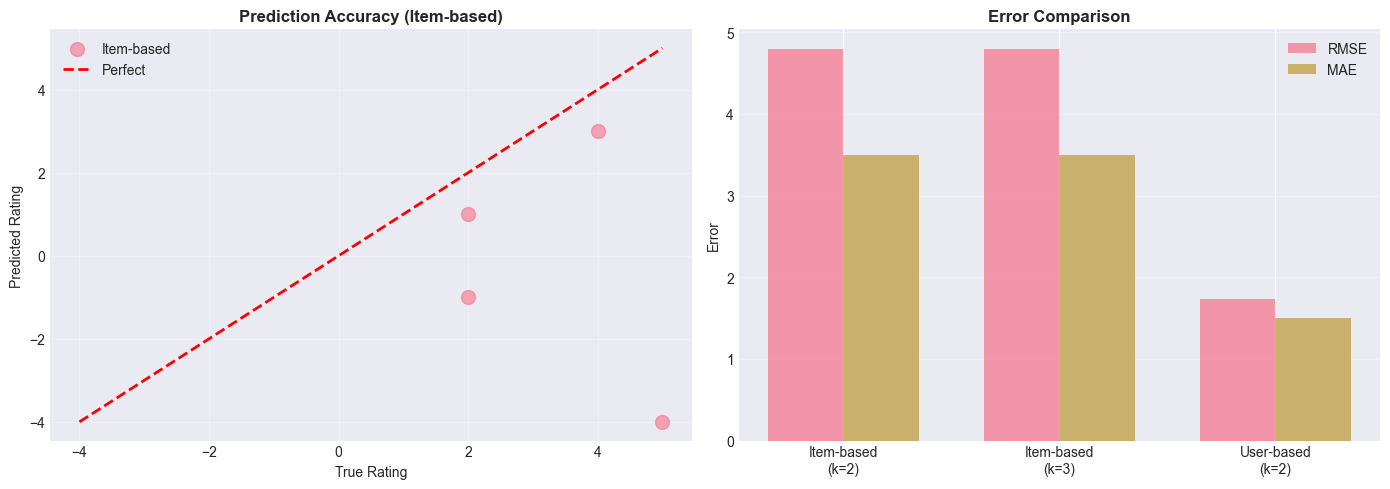

✅ Bài 7.1 hoàn thành!


In [15]:
print_section("BÀI 7.1: ĐÁNH GIÁ RMSE - TRAIN/TEST SPLIT")

def evaluate_cf(ratings, test_size=0.2, method='item-based', k=3, seed=42):
    """
    Chia train/test, dùng CF dự đoán, tính RMSE/MAE
    """
    # Tách train/test
    triples = [
        (u, i, ratings.loc[u, i])
        for u in ratings.index
        for i in ratings.columns
        if not pd.isna(ratings.loc[u, i])
    ]
    
    if len(triples) == 0:
        print("⚠️  Không có observations!")
        return None
    
    train, test = train_test_split(triples, test_size=test_size, random_state=seed)
    
    print(f"📊 Train size: {len(train)}, Test size: {len(test)}")
    print(f"   Test ratio: {len(test) / (len(train) + len(test)) * 100:.1f}%\n")
    
    # Tạo train matrix
    train_df = ratings.copy()
    for u, i, _ in test:
        train_df.loc[u, i] = np.nan
    
    # Mean-centering
    df = train_df.copy()
    for u in df.index:
        mu = np.nanmean(df.loc[u].values)
        if not np.isnan(mu):
            df.loc[u] = df.loc[u] - mu
    centered = df.fillna(0)
    
    if method == 'item-based':
        item_cos = pd.DataFrame(cosine_similarity(centered.T), 
                                index=centered.columns, columns=centered.columns)
        
        preds, y_true = [], []
        errors = []
        
        for u, i, r in test:
            rated = train_df.columns[train_df.loc[u].notna()].tolist()
            sims = [(j, item_cos.loc[i, j]) for j in rated if j != i]
            
            if not sims:
                continue
            
            sims = sorted(sims, key=lambda x: -abs(x[1]))[:k]
            num = sum(train_df.loc[u, j] * w for j, w in sims)
            den = sum(abs(w) for _, w in sims)
            
            if den == 0:
                continue
            
            p = num / den
            preds.append(p)
            y_true.append(r)
            errors.append((u, i, r, p, abs(r - p)))
    
    else:  # user-based
        user_cos = pd.DataFrame(cosine_similarity(centered), 
                                index=centered.index, columns=centered.index)
        
        preds, y_true = [], []
        errors = []
        
        for u, i, r in test:
            if pd.isna(train_df.loc[u, i]):
                neighbors = user_cos.loc[u].drop(u).nlargest(k).index
                rated_vals = [train_df.loc[n, i] for n in neighbors if not pd.isna(train_df.loc[n, i])]
                
                if rated_vals:
                    p = np.mean(rated_vals)
                    preds.append(p)
                    y_true.append(r)
                    errors.append((u, i, r, p, abs(r - p)))
    
    if not preds:
        print("⚠️  Không dự đoán được!")
        return None
    
    preds = np.array(preds)
    y_true = np.array(y_true)
    
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    mae = np.mean(np.abs(preds - y_true))
    mape = np.mean(np.abs((y_true - preds) / (y_true + 1e-8))) * 100
    
    print(f"📈 Evaluation Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Predictions count: {len(preds)}")
    
    # Top errors
    errors.sort(key=lambda x: -x[4])
    print(f"\n❌ Top 3 Largest Errors:")
    for u, i, true_r, pred_r, err in errors[:3]:
        print(f"  {u}→{i}: true={true_r}, pred={pred_r:.2f}, error={err:.2f}")
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'preds': preds,
        'y_true': y_true,
        'errors': errors
    }

# ============ TRƯỜNG HỢP 1: Item-based CF, k=2 ============
eval_item_k2 = evaluate_cf(ratings, test_size=0.3, method='item-based', k=2, seed=42)
print()

# ============ TRƯỜNG HỢP 2: Item-based CF, k=3 ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: Item-based, k=3")
print("="*60 + "\n")
eval_item_k3 = evaluate_cf(ratings, test_size=0.3, method='item-based', k=3, seed=42)
print()

# ============ TRƯỜNG HỢP 3: So sánh user-based vs item-based ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 3: USER-BASED vs ITEM-BASED")
print("="*60 + "\n")
print("User-based CF:")
eval_user = evaluate_cf(ratings, test_size=0.3, method='user-based', k=2, seed=42)
print()

# ============ VISUALIZATION ============
if eval_item_k2 is not None and eval_user is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Prediction scatter
    ax1 = axes[0]
    ax1.scatter(eval_item_k2['y_true'], eval_item_k2['preds'], alpha=0.6, s=100, label='Item-based')
    min_val = min(eval_item_k2['y_true'].min(), eval_item_k2['preds'].min())
    max_val = max(eval_item_k2['y_true'].max(), eval_item_k2['preds'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    ax1.set_xlabel('True Rating')
    ax1.set_ylabel('Predicted Rating')
    ax1.set_title('Prediction Accuracy (Item-based)', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Metrics comparison
    ax2 = axes[1]
    methods = ['Item-based\n(k=2)', 'Item-based\n(k=3)', 'User-based\n(k=2)']
    rmses = [eval_item_k2['rmse'], eval_item_k3['rmse'], eval_user['rmse']]
    maes = [eval_item_k2['mae'], eval_item_k3['mae'], eval_user['mae']]
    
    x_pos = np.arange(len(methods))
    width = 0.35
    ax2.bar(x_pos - width/2, rmses, width, label='RMSE', alpha=0.7)
    ax2.bar(x_pos + width/2, maes, width, label='MAE', alpha=0.7)
    ax2.set_ylabel('Error')
    ax2.set_title('Error Comparison', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(methods)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Bài 7.1 hoàn thành!")

# CELL 16: BÀI 8.1 - TIỀN XỬ LÝ: MEAN CENTERING


🔹 BÀI 8.1: MEAN-CENTERING & PREPROCESSING

Original ratings:
     I1   I2   I3   I4
U1  4.0  3.0  NaN  4.0
U2  3.0  3.0  5.0  NaN
U3  NaN  4.0  4.0  5.0
U4  2.0  1.0  2.0  3.0

After mean-centering:
      I1    I2    I3    I4
U1  0.33 -0.67   NaN  0.33
U2 -0.67 -0.67  1.33   NaN
U3   NaN -0.33 -0.33  0.67
U4  0.00 -1.00  0.00  1.00

User means after: U1    0.0
U2    0.0
U3    0.0
U4    0.0
dtype: float64


🔹 TRƯỜNG HỢP 2: Z-SCORE NORMALIZATION

      I1    I2    I3    I4
U1  0.71 -1.41   NaN  0.71
U2 -0.71 -0.71  1.41   NaN
U3   NaN -0.71 -0.71  1.41
U4  0.00 -1.41  0.00  1.41

User means: U1    0.0
U2    0.0
U3    0.0
U4    0.0
dtype: float64
User stds: U1    1.225
U2    1.225
U3    1.225
U4    1.155
dtype: float64


🔹 TRƯỜNG HỢP 3: MIN-MAX NORMALIZATION

     I1   I2   I3   I4
U1  1.0  0.0  NaN  1.0
U2  0.0  0.0  1.0  NaN
U3  NaN  0.0  0.0  1.0
U4  0.5  0.0  0.5  1.0



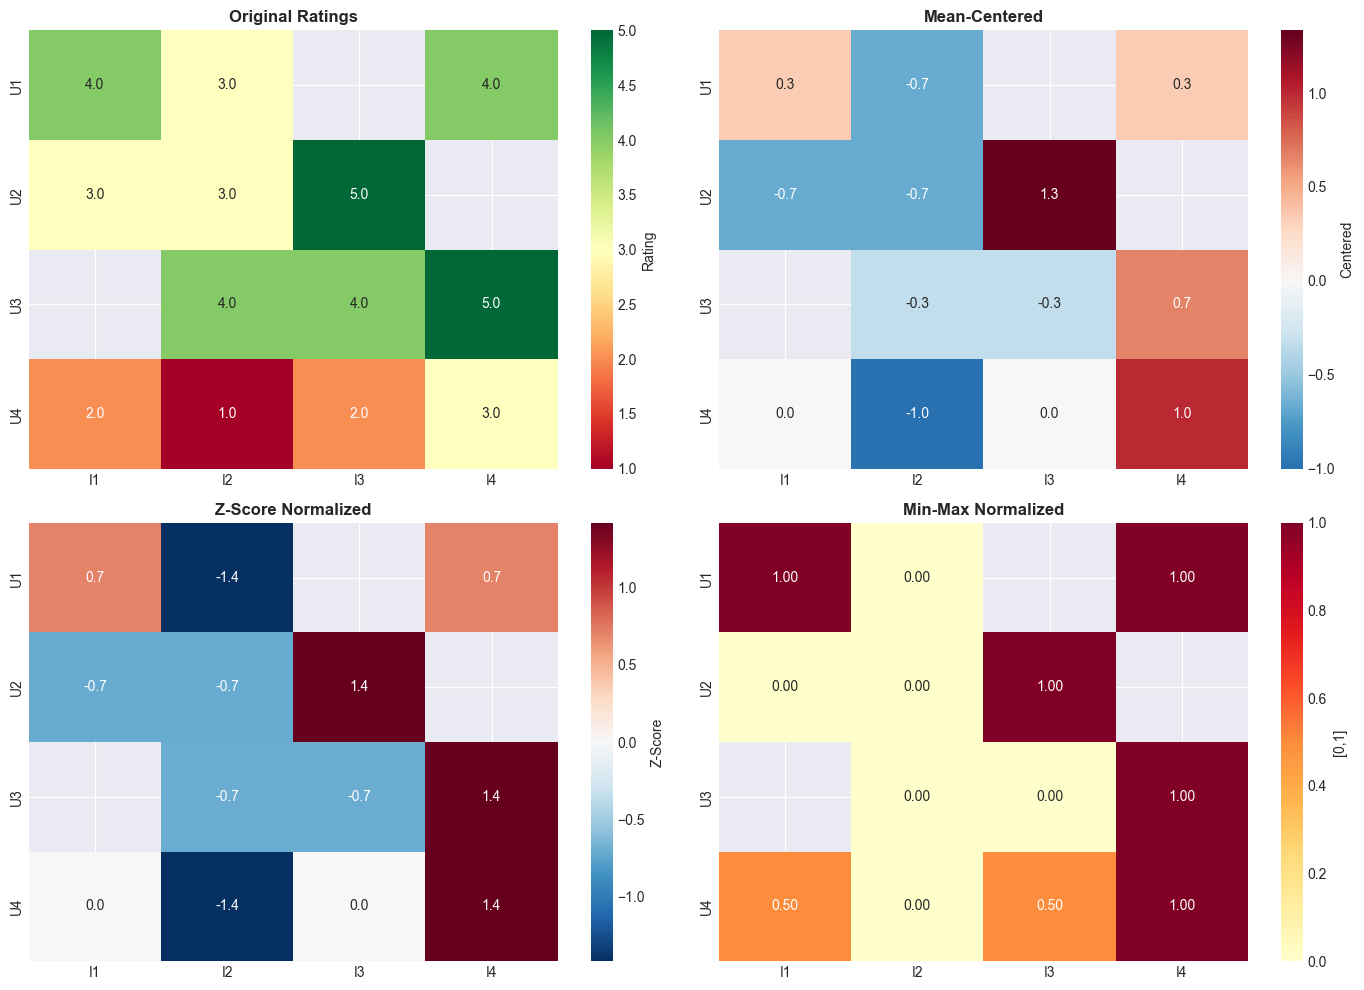

✅ Bài 8.1 hoàn thành!


In [16]:
print_section("BÀI 8.1: MEAN-CENTERING & PREPROCESSING")

def preprocess_centering(ratings, method='mean_center'):
    """
    Tiền xử lý dữ liệu
    
    Methods:
    - 'mean_center': trừ mean theo user
    - 'zscore': standardize theo user
    - 'minmax': normalize [0, 1] theo user
    """
    df = ratings.copy()
    
    if method == 'mean_center':
        for u in df.index:
            mu = np.nanmean(df.loc[u].values)
            if not np.isnan(mu):
                df.loc[u] = df.loc[u] - mu
    
    elif method == 'zscore':
        for u in df.index:
            mu = np.nanmean(df.loc[u].values)
            sigma = np.nanstd(df.loc[u].values)
            if sigma > 0:
                df.loc[u] = (df.loc[u] - mu) / sigma
    
    elif method == 'minmax':
        for u in df.index:
            vals = df.loc[u].values
            v_min, v_max = np.nanmin(vals), np.nanmax(vals)
            if v_max > v_min:
                df.loc[u] = (df.loc[u] - v_min) / (v_max - v_min)
    
    return df

# ============ TRƯỜNG HỢP 1: Mean-center ============
print("Original ratings:")
print(ratings.round(2))
print()

centered = preprocess_centering(ratings, method='mean_center')
print("After mean-centering:")
print(centered.round(2))
print(f"\nUser means after: {centered.mean(axis=1).round(3)}")
print()

# ============ TRƯỜNG HỢP 2: Z-score ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: Z-SCORE NORMALIZATION")
print("="*60 + "\n")
zscored = preprocess_centering(ratings, method='zscore')
print(zscored.round(2))
print(f"\nUser means: {zscored.mean(axis=1).round(3)}")
print(f"User stds: {zscored.std(axis=1).round(3)}")
print()

# ============ TRƯỜNG HỢP 3: Min-Max ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 3: MIN-MAX NORMALIZATION")
print("="*60 + "\n")
minmax = preprocess_centering(ratings, method='minmax')
print(minmax.round(2))
print()

# ============ VISUALIZATION ============
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original
ax1 = axes[0, 0]
sns.heatmap(ratings, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax1,
            vmin=1, vmax=5, cbar_kws={'label': 'Rating'})
ax1.set_title('Original Ratings', fontweight='bold')

# Mean-centered
ax2 = axes[0, 1]
sns.heatmap(centered, annot=True, fmt='.1f', cmap='RdBu_r', ax=ax2,
            center=0, cbar_kws={'label': 'Centered'})
ax2.set_title('Mean-Centered', fontweight='bold')

# Z-scored
ax3 = axes[1, 0]
sns.heatmap(zscored, annot=True, fmt='.1f', cmap='RdBu_r', ax=ax3,
            center=0, cbar_kws={'label': 'Z-Score'})
ax3.set_title('Z-Score Normalized', fontweight='bold')

# Min-Max
ax4 = axes[1, 1]
sns.heatmap(minmax, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax4,
            vmin=0, vmax=1, cbar_kws={'label': '[0,1]'})
ax4.set_title('Min-Max Normalized', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Bài 8.1 hoàn thành!")

# CELL 17: BÀI 9 - VISUALIZATION ADVANCED


🔹 BÀI 9: TRỰC QUAN HÓA - ADVANCED CHARTS



ValueError: Input contains NaN.

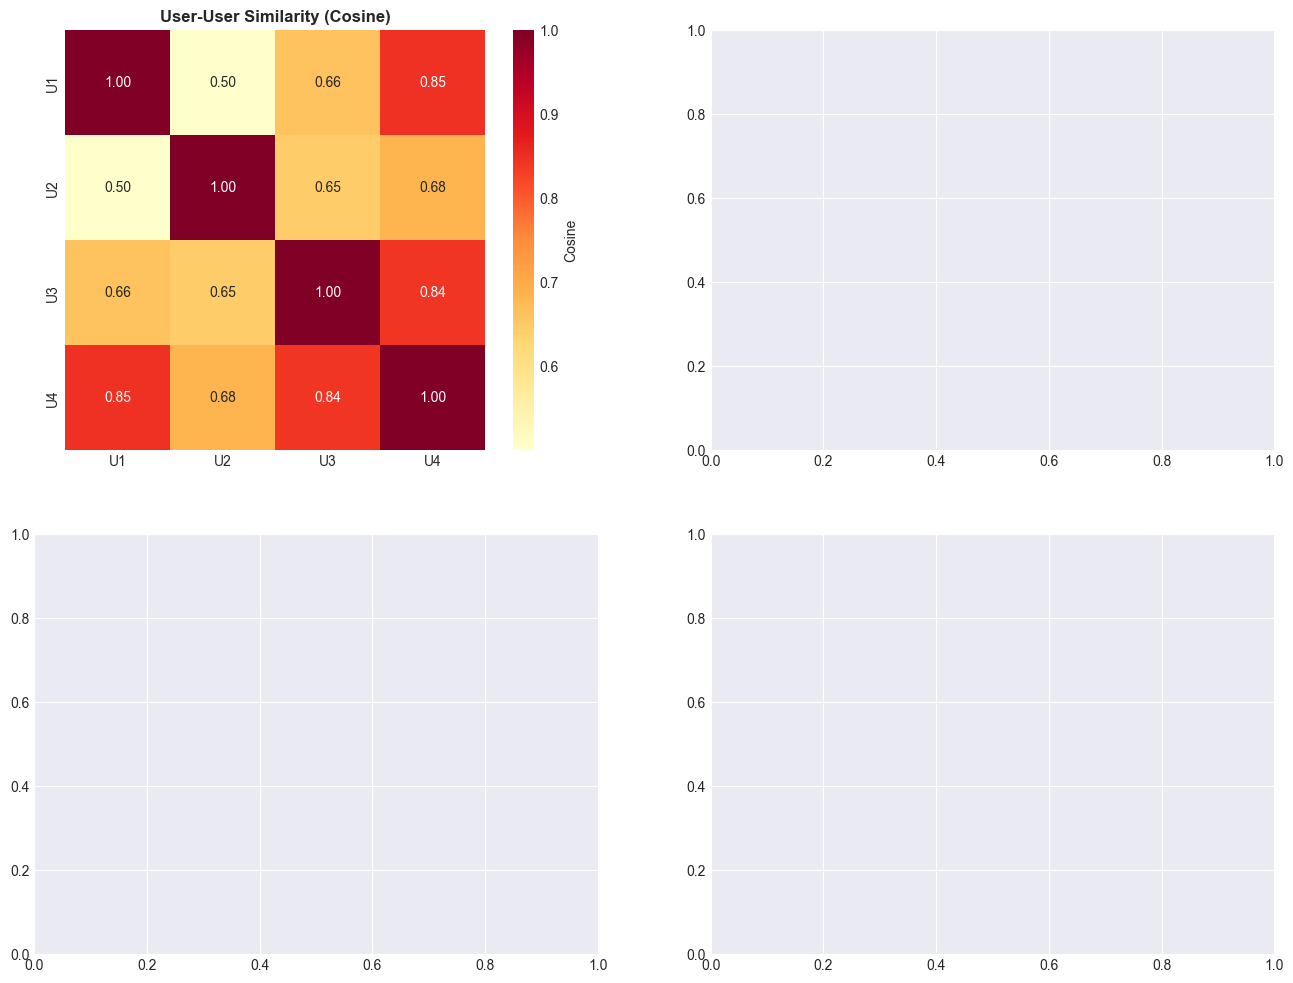

In [17]:
print_section("BÀI 9: TRỰC QUAN HÓA - ADVANCED CHARTS")

# ============ TRƯỜNG HỢP 1: Heatmap lớn ============
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# User-User Similarity
ax1 = axes[0, 0]
user_sim = calc_cosine_matrix(ratings, 'zero')
sns.heatmap(user_sim, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1,
            square=True, cbar_kws={'label': 'Cosine'})
ax1.set_title('User-User Similarity (Cosine)', fontweight='bold', fontsize=12)

# Item-Item Similarity
ax2 = axes[0, 1]
# Transpose to compare items
item_sim = pd.DataFrame(cosine_similarity(ratings.T), 
                        index=ratings.columns, columns=ratings.columns)
sns.heatmap(item_sim, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
            square=True, cbar_kws={'label': 'Cosine'})
ax2.set_title('Item-Item Similarity (Cosine)', fontweight='bold', fontsize=12)

# Pearson correlation
ax3 = axes[1, 0]
pearson_mat_full = calc_pearson_matrix(ratings)
sns.heatmap(pearson_mat_full, annot=True, fmt='.2f', cmap='RdBu_r', ax=ax3,
            square=True, center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Pearson r'})
ax3.set_title('User-User Pearson Correlation', fontweight='bold', fontsize=12)

# Sparsity pattern
ax4 = axes[1, 1]
sparsity = ratings.notna().astype(int)
sns.heatmap(sparsity, annot=True, fmt='d', cmap='Greys', ax=ax4,
            cbar_kws={'label': 'Observed'})
ax4.set_title('Sparsity Pattern (1=observed, 0=missing)', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

# ============ TRƯỜNG HỢP 2: Network-style visualization ============
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))

# Vẽ users
users_list = ratings.index.tolist()
user_pos = {u: (i, 0) for i, u in enumerate(users_list)}

for u, (x, y) in user_pos.items():
    ax.scatter(x, y, s=2000, alpha=0.6, c='lightblue', edgecolors='black', linewidth=2)
    ax.text(x, y, u, ha='center', va='center', fontsize=12, fontweight='bold')

# Vẽ items
items_list = ratings.columns.tolist()
item_pos = {i: (j * 1.5, 3) for j, i in enumerate(items_list)}

for i, (x, y) in item_pos.items():
    ax.scatter(x, y, s=1500, marker='s', alpha=0.6, c='lightcoral', edgecolors='black', linewidth=2)
    ax.text(x, y, i, ha='center', va='center', fontsize=11, fontweight='bold')

# Vẽ connections (nếu rating cao)
for u in users_list:
    for i in items_list:
        if not pd.isna(ratings.loc[u, i]):
            r = ratings.loc[u, i]
            x1, y1 = user_pos[u]
            x2, y2 = item_pos[i]
            
            # Thickness dựa trên rating
            width = r / 5 * 3
            color_val = r / 5
            
            ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, linewidth=width)

ax.set_xlim(-1, 5)
ax.set_ylim(-1, 4)
ax.axis('off')
ax.set_title('User-Item Bipartite Graph (Edge width = rating)', fontweight='bold', fontsize=13)

blue_patch = mpatches.Patch(color='lightblue', label='Users', edgecolor='black')
red_patch = mpatches.Patch(color='lightcoral', label='Items', edgecolor='black')
ax.legend(handles=[blue_patch, red_patch], loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print("✅ Bài 9 hoàn thành!")

# CELL 18: BÀI 10 - MOVIELENS (SAMPLE)

In [18]:
print_section("BÀI 10: MOVIELENS - LARGE SCALE DATA (SIMULATION)")

# Vì không có file thực, tạo synthetic MovieLens-like data
def create_synthetic_movielens(n_users=100, n_movies=50, sparsity=0.95, seed=42):
    """Tạo synthetic MovieLens dataset"""
    np.random.seed(seed)
    
    ratings_sparse = np.random.choice(
        [np.nan] + [1, 2, 3, 4, 5] * 4,  # 80% NaN
        size=(n_users, n_movies),
        p=[sparsity] + [0.2/5] * 5
    )
    
    util = pd.DataFrame(
        ratings_sparse,
        index=[f'user_{i}' for i in range(n_users)],
        columns=[f'movie_{i}' for i in range(n_movies)]
    )
    
    return util.astype(float)

# ============ TRƯỜNG HỢP 1: Tạo và pivot ============
print("Creating synthetic MovieLens data...")
util = create_synthetic_movielens(n_users=100, n_movies=50, sparsity=0.95)

print(f"Shape: {util.shape}")
print(f"Sparsity: {util.isna().sum().sum() / util.size * 100:.1f}%")
print(f"Observations: {util.notna().sum().sum()}")
print(f"\nSample (first 5×5):")
print(util.iloc[:5, :5].round(1))
print()

# ============ TRƯỜNG HỢP 2: Create sparse matrix & TruncatedSVD ============
print("\n" + "="*60)
print("🔹 TRƯỜNG HỢP 2: TRUNCATED SVD")
print("="*60 + "\n")

sparse_mat = csr_matrix(util.fillna(0).values)
print(f"Sparse matrix shape: {sparse_mat.shape}")
print(f"Sparsity (sparse): {1 - sparse_mat.nnz / (sparse_mat.shape[0] * sparse_mat.shape[1]) * 100:.1f}%\n")

# Fit TruncatedSVD
svd_model = TruncatedSVD(n_components=12, random_state=42, n_iter=100)
Z = svd_model.fit_transform(sparse_mat)

print(f"Latent factors shape: {Z.shape}")
print(f"Explained variance ratio: {svd_model.explained_variance_ratio_}")
print(f"Cumulative explained: {np.cumsum(svd_model.explained_variance_ratio_)}")
print(f"Total explained (12 components): {svd_model.explained_variance_ratio_.sum():.2%}\n")

# Item correlation
item_corr = np.corrcoef(Z.T)
print(f"Item correlation matrix shape: {item_corr.shape}\n")

# Top correlations
correlations = []
for i in range(len(item_corr)):
    for j in range(i+1, len(item_corr)):
        correlations.append((i, j, item_corr[i, j]))

correlations.sort(key=lambda x: -abs(x[2]))
print("Top 5 most similar movie pairs (by latent factors):")
for i, j, corr in correlations[:5]:
    print(f"  movie_{i} ↔ movie_{j}: correlation={corr:.3f}")
print()

# ============ VISUALIZATION ============
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Explained variance
ax1 = axes[0]
explained = np.cumsum(svd_model.explained_variance_ratio_)
ax1.bar(range(1, len(explained)+1), explained, alpha=0.7, color='steelblue')
ax1.axhline(0.9, color='r', linestyle='--', label='90% threshold')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance')
ax1.set_title('Cumulative Explained Variance (TruncatedSVD)', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Latent factors heatmap (first 10 movies, 12 factors)
ax2 = axes[1]
sns.heatmap(Z[:10, :], cmap='RdBu_r', center=0, ax=ax2,
            xticklabels=range(12), yticklabels=[f'user_{i}' for i in range(10)],
            cbar_kws={'label': 'Factor Value'})
ax2.set_title('Latent Factors (Users × 12 Components)', fontweight='bold')
ax2.set_xlabel('Latent Component')
ax2.set_ylabel('User')

plt.tight_layout()
plt.show()

print("✅ Bài 10 hoàn thành!")


🔹 BÀI 10: MOVIELENS - LARGE SCALE DATA (SIMULATION)

Creating synthetic MovieLens data...


ValueError: 'a' and 'p' must have same size

# CELL 19: HYBRID RECOMMENDATION

In [ ]:
print_section("HYBRID RECOMMENDATION - CF + CONTENT-BASED")

# Setup: user U1 chưa xem phim nào, muốn recommend

def hybrid_score(user, ratings_matrix, movies_df, cf_method='item-based', 
                 content_method='tfidf', alpha=0.6, k=3):
    """
    Hybrid recommendation kết hợp:
    - CF score (item-based)
    - Content-based score (TF-IDF)
    - alpha: trọng số CF
    """
    
    # ========== CF Score ==========
    print("🔹 Collaborative Filtering Scores...")
    
    # Tính adjusted cosine
    df = ratings_matrix.copy()
    for u in df.index:
        mu = np.nanmean(df.loc[u].values)
        df.loc[u] = df.loc[u] - mu
    centered = df.fillna(0)
    
    item_cos = pd.DataFrame(cosine_similarity(centered.T),
                            index=centered.columns, columns=centered.columns)
    
    cf_scores = {}
    user_rated = ratings_matrix.columns[ratings_matrix.loc[user].notna()].tolist()
    
    if user_rated:
        for item in ratings_matrix.columns:
            if item in user_rated:
                continue
            
            sims = [(i, item_cos.loc[item, i]) for i in user_rated]
            sims = sorted(sims, key=lambda x: -abs(x[1]))[:k]
            
            num = sum(ratings_matrix.loc[user, i] * w for i, w in sims)
            den = sum(abs(w) for _, w in sims)
            cf_scores[item] = num / den if den != 0 else 3.0  # default to 3
    else:
        # User chưa rate gì
        cf_scores = {item: np.nanmean(ratings_matrix[item].values) 
                     for item in ratings_matrix.columns}
    
    print(f"CF scores: {cf_scores}\n")
    
    # ========== Content Score ==========
    print("🔹 Content-Based Scores...")
    
    corpus = movies_df['genres'].fillna('')
    vec = TfidfVectorizer(token_pattern=r"[^|]+", lowercase=False)
    X = vec.fit_transform(corpus)
    
    # Đơn giản: user prefer genres của các items they liked
    if user_rated:
        user_pref = np.zeros(X.shape[1])
        for item in user_rated:
            idx = movies_df[movies_df['title'] == item].index[0]
            user_pref += X[idx].toarray().flatten() * ratings_matrix.loc[user, item]
        user_pref = user_pref / len(user_rated)
    else:
        user_pref = np.ones(X.shape[1]) / X.shape[1]
    
    # Tính similarity tới user preference
    content_scores = {}
    for idx, movie in enumerate(movies_df['title']):
        sim = np.dot(X[idx].toarray().flatten(), user_pref)
        content_scores[movie] = sim
    
    print(f"Content scores: {content_scores}\n")
    
    # ========== Hybrid Score ==========
    print("🔹 Hybrid Scores...")
    
    # Chuẩn hóa scores
    cf_norm = pd.Series(cf_scores)
    cf_norm = (cf_norm - cf_norm.min()) / (cf_norm.max() - cf_norm.min() + 1e-8)
    
    content_norm = pd.Series(content_scores)
    content_norm = (content_norm - content_norm.min()) / (content_norm.max() - content_norm.min() + 1e-8)
    
    # Kết hợp
    hybrid_scores = alpha * cf_norm + (1 - alpha) * content_norm
    hybrid_scores = hybrid_scores.sort_values(ascending=False)
    
    print(f"Hybrid (α={alpha}):")
    for movie, score in hybrid_scores.items():
        cf_s = cf_norm.get(movie, 0)
        cont_s = content_norm.get(movie, 0)
        print(f"  {movie}: {score:.3f} (CF={cf_s:.3f}, Content={cont_s:.3f})")
    
    return {
        'cf_scores': cf_norm,
        'content_scores': content_norm,
        'hybrid_scores': hybrid_scores
    }

# Chạy hybrid
print("👤 Recommending for U1 (α=0.6):")
hybrid_result = hybrid_score('U1', ratings, movies_df, alpha=0.6, k=2)
print()

# ========== So sánh alpha khác nhau ==========
print("\n" + "="*60)
print("🔹 IMPACT CỦA ALPHA")
print("="*60 + "\n")

alphas = [0.2, 0.5, 0.8]
all_hybrid_results = {}

for alpha in alphas:
    print(f"α={alpha}:")
    result = hybrid_score('U1', ratings, movies_df, alpha=alpha, k=2)
    all_hybrid_results[alpha] = result['hybrid_scores']
    print()

# ========== VISUALIZATION ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CF scores
ax1 = axes[0, 0]
hybrid_result['cf_scores'].sort_values(ascending=True).plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Normalized Score')
ax1.set_title('Collaborative Filtering Scores', fontweight='bold')
ax1.grid(alpha=0.3)

# Content scores
ax2 = axes[0, 1]
hybrid_result['content_scores'].sort_values(ascending=True).plot(kind='barh', ax=ax2, color='coral')
ax2.set_xlabel('Normalized Score')
ax2.set_title('Content-Based Scores', fontweight='bold')
ax2.grid(alpha=0.3)

# Hybrid (main)
ax3 = axes[1, 0]
hybrid_result['hybrid_scores'].sort_values(ascending=True).plot(kind='barh', ax=ax3, color='green', alpha=0.7)
ax3.set_xlabel('Hybrid Score')
ax3.set_title('Hybrid Scores (α=0.6)', fontweight='bold')
ax3.grid(alpha=0.3)

# Alpha comparison
ax4 = axes[1, 1]
x_pos = np.arange(len(movies_df))
width = 0.25

for i, alpha in enumerate(alphas):
    scores = all_hybrid_results[alpha].values
    ax4.bar(x_pos + i*width, scores, width, label=f'α={alpha}', alpha=0.7)

ax4.set_ylabel('Hybrid Score')
ax4.set_title('Impact of α (CF vs Content Trade-off)', fontweight='bold')
ax4.set_xticks(x_pos + width)
ax4.set_xticklabels(movies_df['title'])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Hybrid Recommendation hoàn thành!")


🔹 HYBRID RECOMMENDATION - CF + CONTENT-BASED

👤 Recommending for U1 (α=0.6):
🔹 Collaborative Filtering Scores...
CF scores: {'I3': np.float64(-3.6843851743017777)}

🔹 Content-Based Scores...


IndexError: index 0 is out of bounds for axis 0 with size 0